# Distributed Machine Learning with Dask

Dask-ML provides scalable Machine Learning using Dask.
The extension works with minimal changes to the code with all the libraries which follow the Scikit-Learn API (e.g. `fit`, `predict`, ...): sklearn, XGBoost, Tensorflow wrapped using [scikeras](https://www.adriangb.com/scikeras/stable/), PyTorch wrapped with [skorch](https://skorch.readthedocs.io/en/stable/), ...

There are two main challenges which requires scaling the workload on a cluster:

1. Compute Bound problems:
    - data fit in memory, but the workflow is CPU-bound and many operations can be done in parallel
    - sklearn solution is to use joblib for parallel execution (`n_jobs` parameter). Dask scales out the execution to a cluster
    - examples are hyper-parameters search procedures
    
   
2. Memory Bound problems:
    - dataset is larger then the available memory
    - dask provides estimators which work well with Dask Arrays or Dataframes
    - some estimators can be trained incremetally, without seeing the whole dataset
    - maybe the problem is only related to the inference part of an already trained estimator, which can be easily parallelized

In [1]:
# set this variable with one of the following values

# -> 'local'
# -> 'docker_container'
# -> 'docker_cluster'

CLUSTER_TYPE ='docker_cluster'

In [2]:
%env CLUSTER_TYPE $CLUSTER_TYPE

env: CLUSTER_TYPE=docker_cluster


In [3]:
%%script bash --bg --out script_out

if [[ "$CLUSTER_TYPE" != "docker_cluster" ]]; then
    echo "Launching scheduler and worker"
    
    HOSTIP=`hostname -I | xargs`
    
    echo "dask-scheduler --host $HOSTIP --dashboard-address $HOSTIP:8787"
    
    # dask scheduler 
    dask-scheduler --host $HOSTIP --dashboard-address $HOSTIP:8787 &

    # dask worker
    dask-worker $HOSTIP:8786 --memory-limit 1GB --nworkers 2 &

fi

In [4]:
host_ip = !hostname -I | xargs
host_ip = host_ip[0]

In [5]:
from dask.distributed import Client

if CLUSTER_TYPE == 'local':
    
    client = Client()

elif CLUSTER_TYPE == 'docker_container':
    
    client = Client('{}:8786'.format(host_ip))
    
elif CLUSTER_TYPE == 'docker_cluster':
    
    # use the provided master
    client = Client('dask-scheduler:8786')
    
client

Client Scheduler: tcp://dask-scheduler:8786 Dashboard: http://dask-scheduler:8787/status,Cluster Workers: 6 Cores: 6 Memory: 5.59 GiB


In [6]:
from time import time

import matplotlib.pyplot as plt
import dask

import sklearn.datasets
import dask_ml.datasets

import sklearn.cluster
import dask_ml.cluster

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import accuracy_score

## Dask drop-in replacement for sklearn algorithms

Dask reimplements some of the estimators present in `sklearn` following the same API. In particular, machine learning methos which can be writtn down as Numpy routines can be easily parallelized using Dask arrays. 
These variant however include several optimizations and regularizers in order to scale well out of large datasets.

Some algorithms include [Generalized Linear Models](https://ml.dask.org/glm.html), and [Clustering](https://ml.dask.org/clustering.html). In addition, also [preprocessing transformers](https://ml.dask.org/preprocessing.html), such as scalers, are ready to use and they fit and transform data in parallel.

As an example, let's perform a KMeans clustering both using `sklearn` and Dask.

In [7]:
n_samples  = int(1e07)
n_features = 2
centers = 5
rs = 0 # random seed

In [8]:
###########
# SKLEARN #
###########

# let's get a dummy dataset
X, y = sklearn.datasets.make_blobs(n_samples=n_samples, n_features=n_features, centers=centers, random_state=rs)

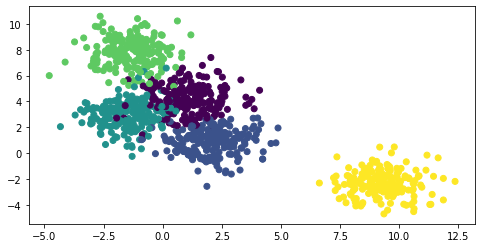

In [9]:
# plot some samples

fig, ax = plt.subplots(figsize=(8,4))
ax.scatter(X[:1000, 0], X[:1000, 1], c=y[:1000])

In [10]:
%%time
model = sklearn.cluster.KMeans(n_clusters=centers)
y_pred = model.fit_predict(X)

CPU times: user 1min 18s, sys: 51.9 s, total: 2min 10s
Wall time: 27.8 s


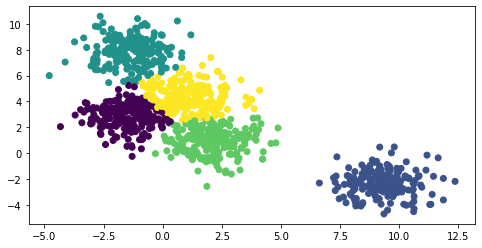

In [11]:
# plot kmeans predictions
fig, ax = plt.subplots(figsize=(8,4))
ax.scatter(X[:1000, 0], X[:1000, 1], c=y_pred[:1000])

In [12]:
###########
# DASK ML #
###########

# create a dummy dataset with dask;
# it returns dask arrays

X, y = dask_ml.datasets.make_blobs(
    n_samples=n_samples, 
    n_features=n_features, 
    centers=centers, 
    random_state=rs, 
    chunks=100000 # size of each chunk
)

In [13]:
X

dask.array<concatenate, shape=(10000000, 2), dtype=float64, chunksize=(100000, 2), chunktype=numpy.ndarray>

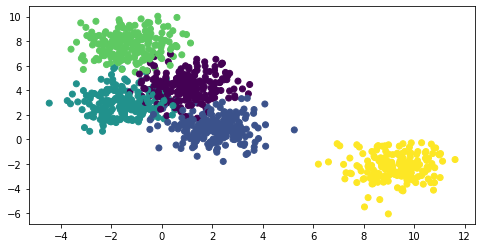

In [14]:
fig, ax = plt.subplots(figsize=(8,4))
ax.scatter(X[:1000, 0], X[:1000, 1], c=y[:1000])

In [15]:
%%time

# same API as sklearn
model = dask_ml.cluster.KMeans(n_clusters=centers)

model.fit(X)
y_pred = model.predict(X)

CPU times: user 3.65 s, sys: 68.3 ms, total: 3.72 s
Wall time: 1min 24s


Dask implementation follows the same API as `sklearn`, so from a code point of view there are no differences.

However, their algorithm is `k-means||` (rather then `k-memans++`) which is described in [Scalable K-Means++](https://arxiv.org/abs/1203.6402). It changes the initialization part of the algorithm and then implements the Lloyd's Algorithm in parallel using the Map-Reduce paradigm.

In [16]:
# now the resulting array is only 38MiB,
# so you can also consider to retrieve it as a normal numpy array

y_pred

dask.array<astype, shape=(10000000,), dtype=int32, chunksize=(100000,), chunktype=numpy.ndarray>

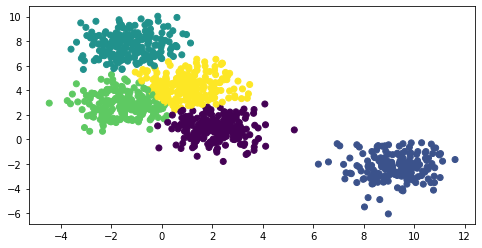

In [17]:
fig, ax = plt.subplots(figsize=(8,4))
ax.scatter(X[:1000, 0], X[:1000, 1], c=y_pred[:1000])

In [18]:
client.restart()

Client Scheduler: tcp://dask-scheduler:8786 Dashboard: http://dask-scheduler:8787/status,Cluster Workers: 6 Cores: 6 Memory: 5.59 GiB


Another interesting reimplementation of a `sklearn` algorithm can be found for the SpectralClustering.

[SpectralClustering](https://scikit-learn.org/stable/modules/clustering.html#spectral-clustering) performs a low-dimension embedding of the affinity matrix between samples, followed by clustering of the components of the eigenvectors in the low dimensional space. The computation of the $N \times N$ affinity matrix is really expensive, and also can lead to out of memory problems when the number of samples increases. 

To overcome this problem, Dask implements the [Nystrom approximation](https://maelfabien.github.io/machinelearning/largescale/#iv-nystr%C3%B6m-approximation) to compute the affinity matrix. The magnitude of the approximation is determined by the `n_components` parameter: higher the value, higher the accuracy of the approximation, at the cost of a longer training time. At the end, the N $\times$ N affinity matrix is approximated by an N $\times$ `n_components` one.

Let's see how this scales by increasing the number of samples.

In [19]:
# I did my test using a 16 cores Rayzen 7 and 32Gb of RAM.
# sklearn implementation starts to crash due to memory limit from 1e05
# For the docker, I used 6 workers each one with 1Gb of memory

n_samples = [int(1e03), int(1e04), int(1.5e04), int(2e04), int(1e05), int(1e06)]

In [20]:
sk_time = []
dml_time = []

for n in n_samples:
    X, _ = sklearn.datasets.make_circles(n_samples=n, random_state=rs, noise=.3, factor=.5)
    model = sklearn.cluster.SpectralClustering(n_clusters=2)
    t0 = time()
    try:
        model.fit(X)
        t1 = time()
    except Exception as e:
        print(e)
        t1 = t0
        
    
    X = dask.array.from_array(X)
    model = dask_ml.cluster.SpectralClustering(n_clusters=2, n_components=10)
    t2 = time()
    model.fit(X)
    t3 = time()
    
    print(f"n = {n:9d} | t_sklearn = {t1-t0:10.6f} | t_daskml = {t3-t2:10.6f}")
    sk_time.append(t1-t0)
    dml_time.append(t3-t2)
    

n =      1000 | t_sklearn =   0.198610 | t_daskml =   6.377589
n =     10000 | t_sklearn =   8.514907 | t_daskml =   5.280702
n =     15000 | t_sklearn =  24.436605 | t_daskml =   6.308903
n =     20000 | t_sklearn =  50.851857 | t_daskml =   7.114057
Unable to allocate 74.5 GiB for an array with shape (100000, 100000) and data type float64
n =    100000 | t_sklearn =   0.000000 | t_daskml =   9.119052
Unable to allocate 7.28 TiB for an array with shape (1000000, 1000000) and data type float64


/usr/local/lib/python3.8/site-packages/distributed/worker.py:3578: UserWarning: Large object of size 7.63 MiB detected in task graph: 
  ("('array-bce8ce374d49e339ece26eb2bc85e052', 0, 0) ... , None, None)))
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(


n =   1000000 | t_sklearn =   0.000000 | t_daskml =  22.445468


In [21]:
sk_time = [x if x>0 else None for x in sk_time]

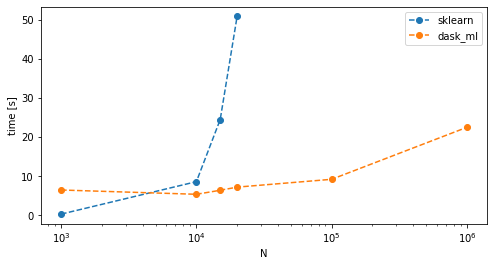

In [22]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(n_samples, sk_time, "o--", label="sklearn")
ax.plot(n_samples, dml_time, "o--", label="dask_ml")
ax.set_xscale("log")
ax.set_xlabel("N")
ax.set_ylabel("time [s]")
ax.legend()
fig.savefig("spectral_clustering.png")

Below I report the results obtained using my home PC with 16 cores Rayzen 7 and 32 Gb of RAM.

You can see how the exact `sklearn` solution scales very bad with the number of samples; in addition, at a certain point the computation of the affinity matrix become infeasible.

On the other hand, the approximate Dask solution scales weel with the increasing amount of samples.

![](spectral_clustering.png)

## Parallel and Distributed learning with joblib

Many `sklearn` algorithms can be parallelized using [Joblib](https://joblib.readthedocs.io/en/latest/), which provides thread-based and process-based parallelism (specified by the `n_jobs` parameter). 

Dask can scale those to a cluster by providing an alternative backend. 

This method is intended to be used for CPU-bound workloads to speed up the computation, not to deal with big data.

As an example, let's see a RandomForest Classifier, which can natively be run in parallel since it is an ensables of estimators. 

In [23]:
n_samples = int(1e05)
n_features = 100
n_informative = 50
n_redundant = 25
n_classes = 5

In [24]:
X, y = sklearn.datasets.make_classification(
    n_samples=n_samples, 
    n_features=n_features, 
    n_informative=n_informative, 
    n_redundant=n_redundant, 
    n_classes=n_classes, 
    random_state=rs
)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y, random_state=rs)

In [26]:
n_estimators = 500
max_depth = 10
n_jobs = -1

model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, n_jobs=n_jobs, random_state=rs)

In [27]:
%%time

model.fit(X_train, y_train)

CPU times: user 4min 28s, sys: 185 ms, total: 4min 28s
Wall time: 18.1 s


RandomForestClassifier(max_depth=10, n_estimators=500, n_jobs=-1,
                       random_state=0)

In [28]:
y_pred = model.predict(X_test)
print(f"Acc = {accuracy_score(y_pred, y_test)}")

Acc = 0.79685


In [29]:
client.restart()

Client Scheduler: tcp://dask-scheduler:8786 Dashboard: http://dask-scheduler:8787/status,Cluster Workers: 6 Cores: 6 Memory: 5.59 GiB


In [30]:
# need to import this from joblib to use alternative backends

from joblib import parallel_backend

In [31]:
model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, n_jobs=n_jobs, random_state=rs)

In [32]:
%%time

# you just need to call the fit under this `with` clause
with parallel_backend("dask"):
    model.fit(X_train, y_train)

CPU times: user 1.2 s, sys: 129 ms, total: 1.33 s
Wall time: 38.1 s


In [33]:
y_pred = model.predict(X_test)
print(f"Acc = {accuracy_score(y_pred, y_test)}")

Acc = 0.79685


In [34]:
client.restart()

Client Scheduler: tcp://dask-scheduler:8786 Dashboard: http://dask-scheduler:8787/status,Cluster Workers: 6 Cores: 6 Memory: 5.59 GiB


## Parallel Predictions

In areal scenario, there is the possibility to already have a trained estimator which needs to make predictions on large daatsets. Dask provides the `ParallelPostFit` wrapper, which parallelize `predict`, `predict_proba` and `transform` methods of the `sklearn` API.

`sklearn` already implemets preditions and transformations in parallel; this meta-estimator is usefull when ther dataset is larger than memory to avoid reading all the data at once.

*NB: This meta-estimator is just to perform inference, it does not parallelize the training!* 

Let's see an example using the MLPRegressor; we train it on a small set of data and then we scale out the inference on a larger dataset.

In [35]:
# create a dummy dataset

X, y = dask_ml.datasets.make_regression(
    n_samples=5000+int(1e07),
    n_features=n_features, 
    n_informative=n_informative, 
    n_targets=1, 
    noise=.1, 
    random_state=rs, 
    chunks=int(1e05)
)

In [36]:
# let's take just the first 5000 elements as our training set
# we will use these to train our estimator

X_train = X[:5000].compute()
y_train = y[:5000].compute()

X_train

array([[ 0.73935755, -0.34522074,  0.35259899, ...,  1.10836687,
         0.29022605, -0.1542753 ],
       [-0.10357219,  0.78293006,  0.2974181 , ...,  1.15427735,
         0.63398644, -0.15428824],
       [ 1.04589624, -0.42903658, -0.11247756, ...,  0.35864973,
         0.73424658,  1.21486279],
       ...,
       [ 0.87533666, -1.20019387,  1.51464448, ...,  0.46374116,
        -0.48150711,  1.08900333],
       [-0.36257152, -0.38951228, -1.12518878, ...,  0.46148605,
         1.758412  , -0.63195507],
       [-0.16631982,  0.1244825 ,  0.9674089 , ..., -1.18482678,
         1.98320582, -0.80995514]])

In [37]:
# the other generated data instead simulate the larger dataset on which we are going to make predictions

X = X[5000:]
y = y[5000:]

X

dask.array<getitem, shape=(10000000, 100), dtype=float64, chunksize=(100000, 100), chunktype=numpy.ndarray>

In [38]:
# just train our model using sklearn 

model = MLPRegressor(
    hidden_layer_sizes=(150, 50),
    activation="relu",
    solver="adam",
    learning_rate="adaptive",
    max_iter=200,
    random_state=rs,
    early_stopping=True,
    validation_fraction=.1,
    verbose=1
)

model.fit(X_train, y_train)

Iteration 1, loss = 98948.80178931
Validation score: 0.002730
Iteration 2, loss = 97765.75734905
Validation score: 0.022542
Iteration 3, loss = 94383.50470512
Validation score: 0.072046
Iteration 4, loss = 87112.74156366
Validation score: 0.168614
Iteration 5, loss = 74474.12754072
Validation score: 0.321428
Iteration 6, loss = 56376.40590764
Validation score: 0.521137
Iteration 7, loss = 35580.26784739
Validation score: 0.725354
Iteration 8, loss = 17434.85124129
Validation score: 0.876198
Iteration 9, loss = 6645.80309413
Validation score: 0.953268
Iteration 10, loss = 2428.79496469
Validation score: 0.979561
Iteration 11, loss = 1169.58371193
Validation score: 0.988619
Iteration 12, loss = 682.26160424
Validation score: 0.993054
Iteration 13, loss = 420.70917645
Validation score: 0.995272
Iteration 14, loss = 294.28825505
Validation score: 0.996527
Iteration 15, loss = 230.93755069
Validation score: 0.997211
Iteration 16, loss = 198.80396355
Validation score: 0.997553
Iteration 17, 

MLPRegressor(early_stopping=True, hidden_layer_sizes=(150, 50),
             learning_rate='adaptive', random_state=0, verbose=1)

In [39]:
# import the wrapper from dask
from dask_ml.wrappers import ParallelPostFit

In [40]:
# scale out the predictions

model = ParallelPostFit(model, scoring="neg_mean_squared_error")
model

ParallelPostFit(estimator=MLPRegressor(early_stopping=True,
                                       hidden_layer_sizes=(150, 50),
                                       learning_rate='adaptive', random_state=0,
                                       verbose=1),
                scoring='neg_mean_squared_error')

In [41]:
# we have performed the prediction on ~ 7Gb and the result is just ~ 76 Mb
# we can now collect the result as a numpy array and proceed with the computation

y_pred = model.predict(X)
y_pred
# call .compute() to actually compute the task

dask.array<_predict, shape=(10000000,), dtype=int64, chunksize=(100000,), chunktype=numpy.ndarray>

In [42]:
print(f"MSE = {-model.score(X,y)}")

MSE = 317.39214400881167


In [43]:
client.restart()

Client Scheduler: tcp://dask-scheduler:8786 Dashboard: http://dask-scheduler:8787/status,Cluster Workers: 6 Cores: 6 Memory: 5.59 GiB


## Incremental Learning

Some estimators can be trained incrementally, without seeing the whole dataset at once (as for batch training for instance). Estimators which support this functionality are the ones that implement the `partial_fit` API. The list of methods which implemets `partial_fit` can be read [here](https://scikit-learn.org/stable/computing/scaling_strategies.html#incremental-learning).

Dask provides the `Incremental` wrapper: with this, Dask pass each block of a Dask Array to the estimator `partial_fit`.

*NB: `Incremental` does not work well hyper-parameters optimizations routines like `sklearn.model_selection.GridSearchCV`; use appropriate Dask methods for this.*

In [44]:
rs =0

In [45]:
n_samples = 5*int(1e06)
n_features = 100
n_informative = 50
n_redundant = 25

In [46]:
import dask_ml.model_selection

X, y = dask_ml.datasets.make_classification(
    n_samples=n_samples,
    n_features=n_features, 
    n_informative=n_informative, 
    n_redundant=n_redundant, 
    n_classes=2, 
    random_state=rs, 
    chunks=5*int(1e04)
)
X_train, X_test, y_train, y_test = dask_ml.model_selection.train_test_split(X, y, test_size=.1, random_state=rs)
X_train

/usr/local/lib/python3.8/site-packages/dask_ml/datasets.py:377: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  z0 = X[:, informative_idx].dot(beta[informative_idx])


dask.array<concatenate, shape=(4500000, 100), dtype=float64, chunksize=(45000, 100), chunktype=numpy.ndarray>

In [47]:
from dask_ml.wrappers import Incremental

model = MLPClassifier(
    hidden_layer_sizes=(100,50),
    activation="relu",
    solver="adam",
    learning_rate="adaptive",
    max_iter=100,
    random_state=rs,
    early_stopping=False,
    verbose=1
)

model = Incremental(model, scoring="accuracy")
model

Incremental(estimator=MLPClassifier(hidden_layer_sizes=(100, 50),
                                    learning_rate='adaptive', max_iter=100,
                                    random_state=0, verbose=1),
            scoring='accuracy')

In [48]:
%%time

# when fitting an Incremental estimator, you must provide the possible labels
# since not all batches may contain all the different classes

model.fit(X_train, y_train, classes=[0,1])

CPU times: user 165 ms, sys: 7.16 ms, total: 172 ms
Wall time: 55.5 s


Incremental(estimator=MLPClassifier(hidden_layer_sizes=(100, 50),
                                    learning_rate='adaptive', max_iter=100,
                                    random_state=0, verbose=1),
            scoring='accuracy')

In [49]:
model.score(X_test, y_test)

0.903134

In [50]:
client.restart()

Client Scheduler: tcp://dask-scheduler:8786 Dashboard: http://dask-scheduler:8787/status,Cluster Workers: 6 Cores: 6 Memory: 5.59 GiB


## Exercise

In the `dateset/cifar10` folder you can find the [cifar10](https://keras.io/api/datasets/cifar10/) dataset. It is composed by $32 \times 32$ RGB images, where each pixel is an integer in the range `[0, 255]`, belonging to 10 different classes. Images have been flattened and then saved as a dataframe (one image per row) in parquet format. In addition, there are two more columns representing the class label and if the image is part of the training or test set.

1. Read the parquet files using Dask and plot some example images with their labels.
2. Split the data into training and test set using the appropriate column.
3. Try a couple of classification algorithms on the flatten images without any preprocessing:
    - distribute the training of the RandomForestClassifier (or XGBoost if you want to install it) using joblib with dask backend
    - perform an Incremental learning with the MLPClassifier
    - try an hyper-parameter search on the MLPClassifier usign the [HyperbandSearchCV](https://ml.dask.org/modules/generated/dask_ml.model_selection.HyperbandSearchCV.html#dask_ml.model_selection.HyperbandSearchCV). This algorithm essentially performs a RandomizedCV, but it stops estimators that perform poorly.
    - use dask PCA and LogisticRegression
4. Convert the images to GrayScale and rescale the pixels in the range `[0,1]`. Train an `SGDClassifier` with `sklearn` on the test set (which is smaller), and then use Dask wrapper to perform the prediction of the training one.
5. **Extra**. Tensorflow/Keras and PyTorch do not follow the `sklearn` API directly; hence it is not immediate to use dask with them. However, you can use some wrappers (`scikeras` and `skorch` respectively) which provide such API to those libraries. Build a simple convolutional network (eg. one conv layers and a couple of dense one) with Keras, use `scikeras` wrapper and Dask Incremental learning.